# Notes on Chapter 2 of Statistical Rethinking 2nd Edition by Richard McElreath

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from math import pi
tfd = tfp.distributions
tfm = tf.math

In [2]:
%load_ext rpy2.ipython

In [3]:
# Tensorflow gives a lot of warnings that don't have workarounds to avoid the warning; thus we need to disable them manually
def NestedGradientWarningFilter(record):
    return not record.getMessage().startswith('Calling GradientTape.gradient on a persistent tape inside its context')

### 2.1

In [4]:
%%R

ways <- c(0, 3, 8, 9, 0)
ways/sum(ways)

[1] 0.00 0.15 0.40 0.45 0.00


In [5]:
ways = tf.constant([0, 3, 8, 9, 0])
ways/tfm.reduce_sum(ways)

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.  , 0.15, 0.4 , 0.45, 0.  ])>

### 2.2

In [6]:
%%R

dbinom(6, size=9, prob=0.5)

[1] 0.1640625


In [7]:
float(tfd.Binomial(total_count=9, probs=0.5).prob(6))

0.16406261920928955

### 2.3

In [8]:
%%R

p_grid <- seq(from=0, to=1, length.out=20)
prior <- rep(1, 20)
likelyhood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelyhood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)

In [9]:
# BUG: Tensorflow probability returns NaNs for some 0 values of the probability density function (e.g. 1.0)
# This will set them to zero (but might have performance implications)
def zero_nans(x):
    return tf.where(tfm.is_nan(x), tf.zeros_like(x), x)

p_grid = tf.linspace(0., 1, 20)
prior = tf.ones_like(p_grid)
likelyhood = zero_nans(tfd.Binomial(total_count=9, probs=p_grid).prob(6))
unnormalized_posterior = likelyhood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)

### 2.4

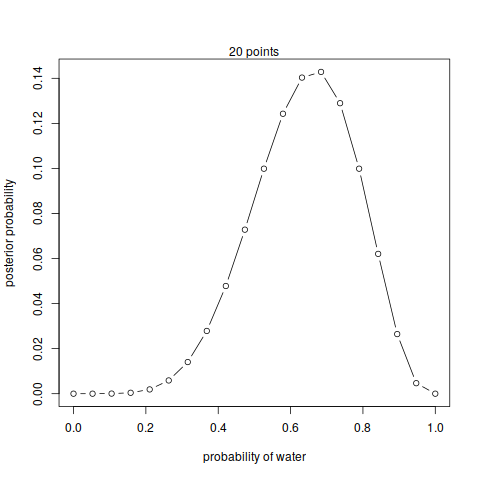

In [10]:
%%R

plot(p_grid, posterior, type="b", xlab="probability of water", ylab="posterior probability")
mtext("20 points")

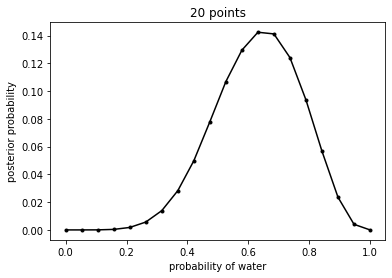

In [25]:
plt.plot(p_grid, posterior, "k.-")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points');

### 2.5


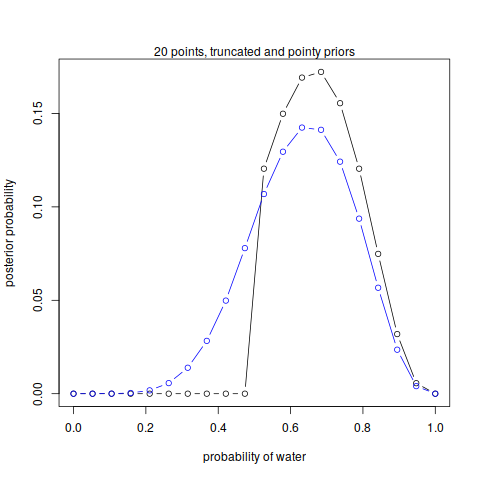

In [12]:
%%R

p_grid <- seq(from=0, to=1, length.out=20)

prior <- ifelse(p_grid < 0.5, 0, 1)
likelyhood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelyhood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)
plot(p_grid, posterior, type="b", xlab="probability of water", ylab="posterior probability")

prior <- exp(-0.5*abs(p_grid - 0.5))
likelyhood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelyhood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)
lines(p_grid, posterior, type="b", col="blue")

mtext("20 points, truncated and pointy priors")

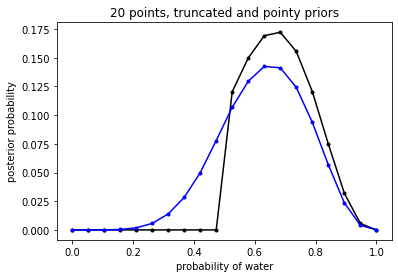

In [13]:
p_grid = tf.linspace(0., 1, 20)

prior = tf.where(p_grid < 0.5, tf.zeros_like(p_grid), tf.ones_like(p_grid))
likelyhood = zero_nans(tfd.Binomial(total_count=9, probs=p_grid).prob(6))
unnormalized_posterior = likelyhood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
plt.plot(p_grid, posterior, ".-k")

prior = tfm.exp(-0.5*tfm.abs(p_grid - 0.5))
likelyhood = zero_nans(tfd.Binomial(total_count=9, probs=p_grid).prob(6))
unnormalized_posterior = likelyhood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
plt.plot(p_grid, posterior, ".-b")

plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points, truncated and pointy priors');

### 2.6

In [16]:
%%R

library(rethinking)
globe.qa <- quap(
    alist(
        W ~ dbinom(W+L, p),
        p ~ dunif(0, 1)
    ),
    data=list(W=6, L=3)
)

precis(globe.qa)

  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


I don't see an equivalent of the author's library for tensorflow probability, so we'll need to implement the quadratic approximation by hand...

In [17]:
W = tf.constant(6.)
L = tf.constant(3.)

def likelihood(p):
    N = W + L
    return tfd.Binomial(N, probs=p).prob(W) * tfd.Uniform().prob(p)

# find the point of maximum likelihood
mu = tf.Variable(0.5, 'mu')
optimizer = tf.keras.optimizers.Adam(0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        loss = tfm.negative(tfm.log(likelihood(mu)))
    gradients = tape.gradient(loss, [mu])
    optimizer.apply_gradients(zip(gradients, [mu]))
    
# find the Hessian at that point
with tf.GradientTape(persistent=True) as tape:
    loss = tfm.negative(tfm.log(likelihood(mu)))
    tf.get_logger().addFilter(NestedGradientWarningFilter)
    gradients = tape.gradient(loss, [mu])
    tf.get_logger().removeFilter(NestedGradientWarningFilter)
hessians = tape.jacobian(gradients[0], mu)

sigma = tfm.sqrt(1/hessians)

print("  mean   sd 5.5% 94.5%")
print(f'p {float(mu):.2f} {float(sigma):.2f} {float(mu - 1.6*sigma):.2f}  {float(mu + 1.6*sigma):.2f}')

  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


### 2.7

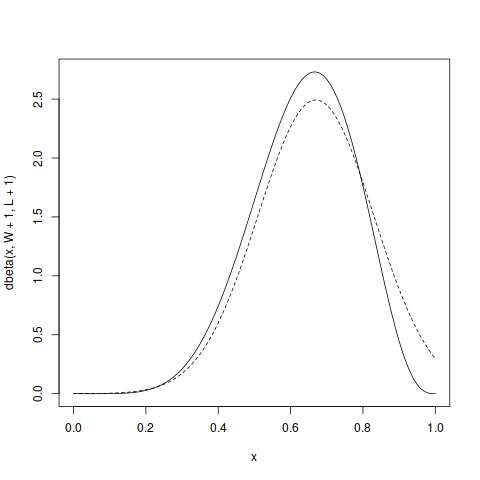

In [19]:
%%R

W <- 6
L <- 3
curve(dbeta(x, W+1, L+1), from=0, to=1)
curve(dnorm(x, 0.67, 0.16), lty=2, add=TRUE)

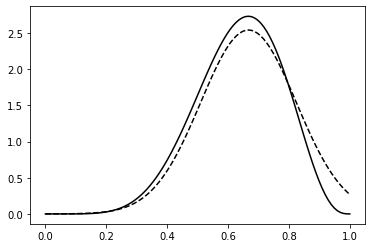

In [26]:
W = 6.
L = 3.
x = tf.linspace(0., 1., 100)
plt.plot(x, tfd.Beta(W + 1, L + 1).prob(x), 'k-')
plt.plot(x, tfd.Normal(mu, sigma).prob(x), 'k--');